### Simple script computing the Kolmogorov-Smirnov test for our Ice data

In [32]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from scipy import stats

In [9]:
path_data = "../dataset/"
buoys_df = pd.read_csv(f"{path_data}prepared_buoy_data.csv", index_col=[0, 1])

buoys_df

lat  lon  arome_t2m  temp_air  temp_surf  \
KVS_BUOY_IDX                                                                   
KVS_SvalMIZ_01 2025-04-27 10:00:00  NaN  NaN        NaN       NaN        NaN   
               2025-04-27 11:00:00  NaN  NaN        NaN       NaN        NaN   
               2025-04-27 12:00:00  NaN  NaN        NaN       NaN        NaN   
               2025-04-27 13:00:00  NaN  NaN        NaN       NaN        NaN   
               2025-04-27 14:00:00  NaN  NaN        NaN       NaN        NaN   
...                                 ...  ...        ...       ...        ...   
KVS_SvalMIZ_25 2025-07-10 04:00:00  NaN  NaN        NaN       NaN        NaN   
               2025-07-10 05:00:00  NaN  NaN        NaN       NaN        NaN   
               2025-07-10 06:00:00  NaN  NaN        NaN       NaN        NaN   
               2025-07-10 07:00:00  NaN  NaN        NaN       NaN        NaN   
               2025-07-10 08:00:00  NaN  NaN        NaN       NaN        NaN   

                                    temp_snow_ice  temp_ice  sic  
KVS_BUOY_IDX                                                      
KVS_SvalMIZ_01 2025-04-27 10:00:00            NaN       NaN  NaN  
               2025-04-27 11:00:00            NaN       NaN  NaN  
               2025-04-27 12:00:00            NaN       NaN  NaN  
               2025-04-27 13:00:00            NaN       NaN  NaN  
               2025-04-27 14:00:00            NaN       NaN  NaN  
...                                           ...       ...  ...  
KVS_SvalMIZ_25 2025-07-10 04:00:00            NaN       NaN  NaN  
               2025-07-10 05:00:00            NaN       NaN  NaN  
               2025-07-10 06:00:00            NaN       NaN  NaN  
               2025-07-10 07:00:00            NaN       NaN  NaN  
               2025-07-10 08:00:00            NaN       NaN  NaN  

[35380 rows x 8 columns]

In [123]:
kvs_10 = buoys_df.loc['KVS_SvalMIZ_07'].dropna()
kvs_10_index = kvs_10.index.values
kvs_10_t1m = np.array(kvs_10['temp_air'].values)
kvs_10_t2m = np.array(kvs_10['arome_t2m'].values)
kvs_10_sic = np.array(kvs_10['sic'].values)
kvs_10_ist = np.array(kvs_10['temp_ice'].values)

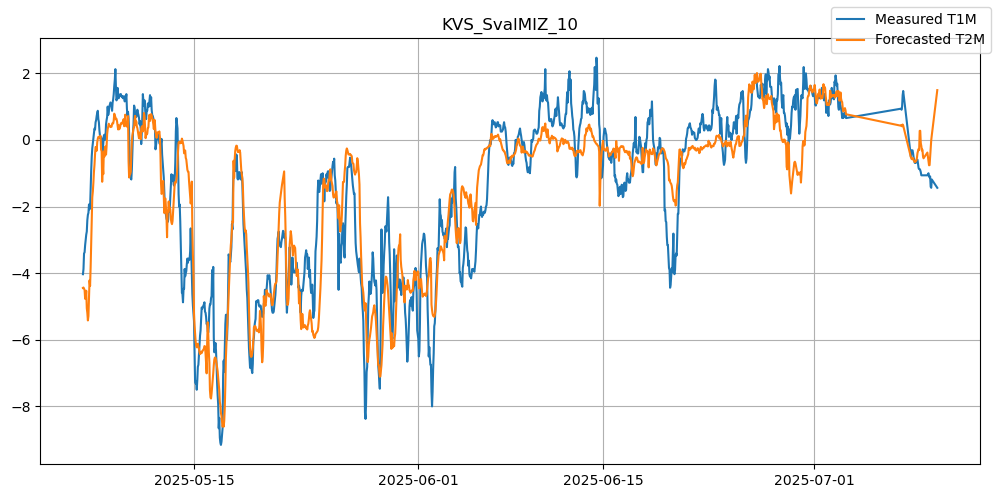

In [124]:
fig, ax = plt.subplots(nrows = 1, figsize = (10, 5))

ax.plot(pd.to_datetime(kvs_10_index), kvs_10_t1m, label = 'Measured T1M')
ax.plot(pd.to_datetime(kvs_10_index), kvs_10_t2m, label = 'Forecasted T2M')
ax.set_title('KVS_SvalMIZ_10')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.grid()
fig.legend()
fig.tight_layout()

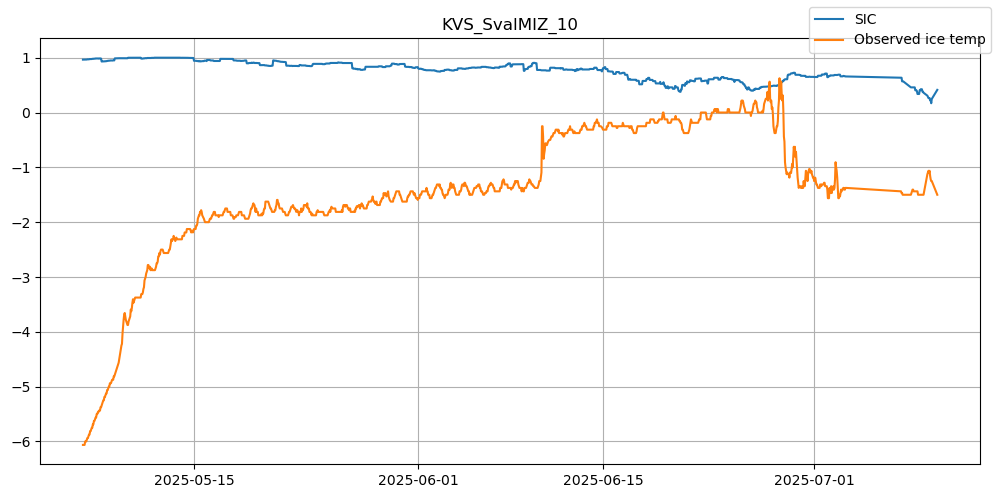

In [125]:
fig, ax = plt.subplots(nrows = 1, figsize = (10, 5))
ax.plot(pd.to_datetime(kvs_10_index), kvs_10_sic, label = 'SIC')

ax.plot(pd.to_datetime(kvs_10_index), kvs_10_ist, label = 'Observed ice temp')
ax.set_title('KVS_SvalMIZ_10')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.grid()
fig.legend()
fig.tight_layout()

#### Visualize as histogram

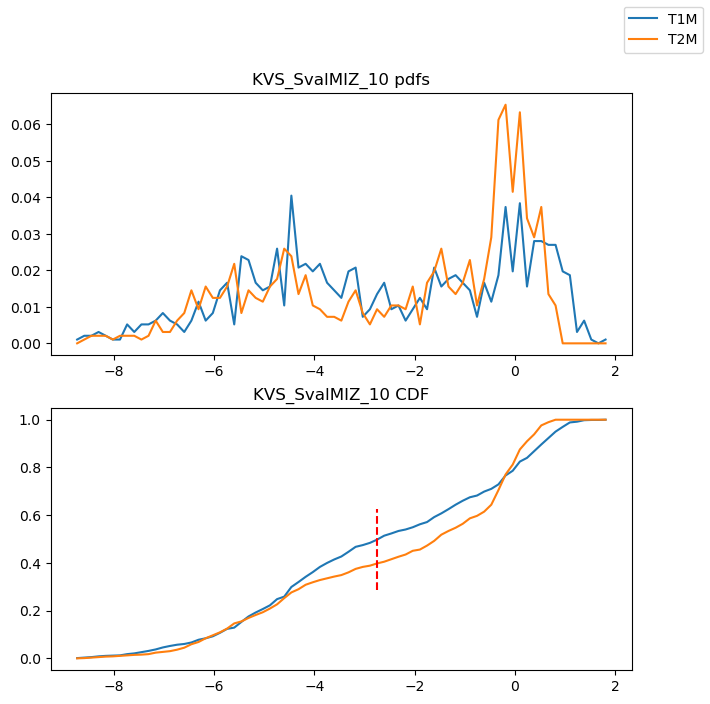

In [92]:

all_data = np.concatenate([np.asarray(kvs_10_t1m), np.asarray(kvs_10_t2m)])
bin_edges = np.linspace(all_data.min(), all_data.max(), 76)

counts, _ = np.histogram(kvs_10_t1m, bins = bin_edges, density = True)
pdf = counts / sum(counts)
cdf_t1m = np.cumsum(pdf)
fig, ax = plt.subplots(nrows = 2, figsize = (7.5, 7.5))
ax[0].set_title('KVS_SvalMIZ_10 pdfs')
ax[0].plot(bin_edges[1:], pdf, label = 'T1M')

ax[1].set_title('KVS_SvalMIZ_10 CDF')
ax[1].plot(bin_edges[1:], np.cumsum(pdf))

counts, _ = np.histogram(kvs_10_t2m, bins = bin_edges, density = True)

pdf = counts / sum(counts)
cdf_t2m = np.cumsum(pdf)

ax[0].plot(bin_edges[1:], pdf, label = 'T2M')
ax[1].plot(bin_edges[1:], np.cumsum(pdf))

D_nm = np.max(np.abs(cdf_t2m - cdf_t1m))
loc = np.argmax(np.abs(cdf_t2m - cdf_t1m))

ax[1].axvline(bin_edges[loc], ymin = cdf_t2m[loc] - 0.1, ymax = cdf_t1m[loc] + 0.1, ls = '--', c = 'r')

fig.legend()

#### Kolmogorov-Smirnov (ice) test

$H_0$: same distribution. Rejected if test-statistic D is bigger than the computed statistic $c(\alpha)$

In [105]:
alpha = .05
c_a = np.sqrt(-np.log(.5*alpha)*.5)

In [108]:
n = kvs_10.shape[0]
scaler_1 = np.sqrt((n+n) / (n*n))
scaler_2 = np.sqrt((n*n) / (n+n))
# Test 1

test_1 = D_nm > c_a*scaler_1

print(f"Two sample KS test. D_nm = {D_nm:.3f}, Critical value: {c_a * scaler_1:.3f}, rejected = {test_1}")

# Test 2
test_2 = scaler_2 * D_nm >  c_a
print(f"Two sample KS test. D_nm = {scaler_2 * D_nm:.3f}, Critical value: {c_a:.3f}, rejected = {test_2}")

Two sample KS test. D_nm = 0.109, Critical value: 0.062, rejected = True
Two sample KS test. D_nm = 2.393, Critical value: 1.358, rejected = True
